In [1]:
# !pip install optuna
# !pip install category_encoders
# !pip install catboost
# !pip install xgboost
# !pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import category_encoders as enc
from datetime import datetime
from google.colab import files
from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import re
import math
import gc

warnings.filterwarnings("ignore")

In [3]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

In [4]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna

In [5]:
plt.style.use('fivethirtyeight')

In [6]:
def show_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, suffixes=("",suffix))

def get_feature_importance(clf, dataframe, feature_list, top_n=10):
    res = pd.DataFrame({'Feature':dataframe[feature_list].columns, 'Importance': clf.feature_importances_})
    return res.sort_values('Importance', ascending=False).head(top_n)

def generate_date_features(df, fldname, drop=False, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
    
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub("[Dd]ate$", '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 
            'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
  
    if time: attr = attr + ['Hour', 'Minute', 'Second']

    for n in attr: df[targ_pre + '_' + n] = getattr(fld.dt, n.lower())
    df[targ_pre+"_Is_weekend"] = df[targ_pre+"_Dayofweek"].apply(lambda x:True if x==5 or x==6 else False)
    df[targ_pre+"_Elapsed"] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)
    return df

def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in tqdm_notebook(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

def get_optimal_f1_thresh(target, oofs):
    thresholds = np.arange(0, 100)/100
    thresh_scores = []
    for thresh in thresholds:
        oofs_rounded = (oofs > thresh) * 1
        thresh_score = metrics.f1_score(target, oofs_rounded)
        thresh_scores.append(thresh_score)

    all_thresholds_and_scores = pd.Series(index = thresholds, data = thresh_scores)
    all_thresholds_and_scores.plot(figsize=(10, 6), fontsize=14)

    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('F1 Score', fontsize=14)

    return all_thresholds_and_scores.sort_values(ascending=False).index.values[0]

In [7]:
def objective(trial, data, features, target, clf_type='LGB', gpu_enabled=False, fold = 0):
    
    xtrain = data[data[FOLD_COL] != fold].reset_index(drop=True)
    xvalid = data[data[FOLD_COL] == fold].reset_index(drop=True)
    
    ytrain = xtrain[target]
    yvalid = xvalid[target]

    xtrain = xtrain[features]
    xvalid = xvalid[features]
    
    params = {
        'random_state': trial.suggest_categorical('random_state', [RANDOM_STATE]),
        'n_estimators': trial.suggest_categorical('n_estimators', [25000]) ,
        'learning_rate': trial.suggest_uniform('learning_rate',0.01, 0.1),
        'max_depth': trial.suggest_int("max_depth", 3, 15),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 100.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 0.8),
        'subsample': trial.suggest_float("subsample", 0.1, 0.8),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 100.0),
    }
    
    if clf_type == 'LGB':
        params['objective'] = trial.suggest_categorical('objective', ['binary'])
        params['metric'] = trial.suggest_categorical('metric', ['binary_logloss'])
        params['num_leaves'] = trial.suggest_int('num_leaves', 10, 300)
        params['min_child_samples'] = trial.suggest_int('min_child_samples', 5, 100)
        params['min_data_per_group'] = trial.suggest_int('min_data_per_group', 50, 200)
        
        if gpu_enabled:
            params['device'] = trial.suggest_categorical('device', ['gpu'])
            params['gpu_platform_id'] = trial.suggest_categorical('gpu_platform_id', [0])
            params['gpu_device_id'] = trial.suggest_categorical('gpu_device_id', [0])
        else:
            params['n_jobs'] = trial.suggest_categorical('n_jobs', [-1])
        
        clf = LGBMClassifier(**params)
    
    elif clf_type == 'XGB':
        params['objective'] = trial.suggest_categorical('objective', ['binary:logistic'])
        params['eval_metric'] = trial.suggest_categorical('eval_metric', ['logloss'])
        params['use_label_encoder'] = trial.suggest_categorical('use_label_encoder', [False])
        
        if gpu_enabled:
            params['tree_method'] = trial.suggest_categorical('tree_method', ['gpu_hist'])
            # params['gpu_id'] = 0
            params['predictor'] = trial.suggest_categorical('predictor', ['gpu_predictor'])
        else:
            params['n_jobs'] = trial.suggest_categorical('n_jobs', [-1])

        clf = XGBClassifier(**params)
        
    elif clf_type == 'CTB':
        params['loss_function'] = trial.suggest_categorical('loss_function', ['Logloss'])
        params['max_bin'] = trial.suggest_int('max_bin', 200, 400)
        params['min_data_in_leaf'] = trial.suggest_int('min_data_in_leaf', 1, 300)
        params['use_best_model'] = trial.suggest_categorical('use_best_model', [True])
        params['random_strength'] = trial.suggest_uniform('random_strength', 10, 50)
      
        del params['reg_alpha']
        del params['colsample_bytree']
        
        if gpu_enabled:
            params['task_type'] = trial.suggest_categorical('task_type', ['GPU'])
            # params['devices'] = '0:1'
            params['bootstrap_type'] = trial.suggest_categorical('bootstrap_type', ['Poisson'])
        else:
            params['rsm'] = trial.suggest_float("rsm", 0.1, 1.0)
    
        clf = CatBoostClassifier(**params)
        
    _ = clf.fit(xtrain
                , ytrain
                , early_stopping_rounds=200
                , eval_set=[(xtrain, ytrain), (xvalid, yvalid)]
                , verbose=0
               )

    preds_valid = clf.predict_proba(xvalid)[:,1]
    score = metrics.roc_auc_score(yvalid, preds_valid)
    return score

In [8]:
def run_clf(clf, fit_params, train_data, test_data, features, TARGET_COL, folds = 5, threshold=0.5):
    
    oofs = np.zeros(len(train_data))
    test_predictions = np.zeros((len(test_data)))
    model_scores = []
    y = train_data[TARGET_COL]
    
    for fold in range(folds):
        
        print(f'\n------------- Fold {fold + 1} -------------')

        xtrain = train_data[train_data[FOLD_COL] != fold]
        xvalid = train_data[train_data[FOLD_COL] == fold]
        xtest = test_data.copy()

        ytrain = xtrain[TARGET_COL]
        yvalid = xvalid[TARGET_COL]

        val_idx = xvalid.index.values
            
        xtrain = xtrain.reset_index(drop=True)
        xvalid = xvalid.reset_index(drop=True)
      
        xtrain = xtrain[features]
        xvalid = xvalid[features]
        xtest  = xtest[features]

        ############# Fitting and Predicting ################

        _ = clf.fit(xtrain
                  , ytrain
                  , eval_set=[(xtrain, ytrain), (xvalid, yvalid)]
                  , **fit_params
                  )

        preds_score = clf.predict_proba(xvalid)[:,1]
        preds_val = np.where(preds_score > threshold, 1, 0)
        preds_test = clf.predict_proba(xtest)[:,1]

        fold_score = np.round(metrics.f1_score(yvalid, preds_val), 5)
        model_scores.append(fold_score)
        print(f'\nF1 for validation set is {fold_score}\n')

        # print(preds_test[0:10])
      
        oofs[val_idx] = preds_score
        test_predictions += preds_test / folds

    print(f'\nCV F1 score: {np.round(np.mean(model_scores), 5)}')
    
    oofs_score = np.round(metrics.f1_score(y, np.where(oofs > threshold, 1, 0)), 5)
    print(f'\nOOF F1 score: {oofs_score}')

    return test_predictions, model_scores, clf, oofs

In [9]:
DIRECTORY_PATH = '/content/data'
TRAIN_CSV = DIRECTORY_PATH + '/train_qWM28Yl.csv'
TEST_CSV = DIRECTORY_PATH + '/test_zo1G9sv.csv'
SUBMISSION_CSV = DIRECTORY_PATH + '/sample_submission_KvRh9Sx.csv'

In [10]:
df_train = pd.read_csv(TRAIN_CSV)
df_test = pd.read_csv(TEST_CSV)

df_submission = pd.read_csv(SUBMISSION_CSV)

In [11]:
df_train.shape, df_test.shape, df_submission.shape

((58592, 44), (39063, 43), (39063, 2))

In [12]:
show_all(df_train.head())

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [13]:
show_all(df_test.head())

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating
0,ID58593,0.341732,0.00,0.586538,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0
1,ID58594,0.307241,0.13,0.442308,C8,8794,1,B2,M6,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,K Series Dual jet,2,No,Yes,No,Yes,No,Drum,1197,4,Manual,5,Electric,4.8,3845,1735,1530,1335,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2
2,ID58595,0.327924,0.12,0.451923,C8,8794,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2
3,ID58596,0.782654,0.01,0.461538,C5,34738,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0
4,ID58597,1.233404,0.02,0.634615,C5,34738,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0


In [14]:
show_all(df_submission.head())

,policy_id,is_claim
0,ID58593,1
1,ID58594,1
2,ID58595,1
3,ID58596,1
4,ID58597,1


In [15]:
ID_COL = 'policy_id'
TARGET_COL = 'is_claim'
RANDOM_STATE = 19920803
FOLD_COL = 'fold'
N_TRAILS = 20
N_FOLDS = 10

In [16]:
df_train[TARGET_COL].describe()

count    58592.000000
mean         0.063968
std          0.244698
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_claim, dtype: float64

In [17]:
df_train[TARGET_COL].value_counts()

0    54844
1     3748
Name: is_claim, dtype: int64

In [18]:
df_train[TARGET_COL].value_counts(normalize=True)

0    0.936032
1    0.063968
Name: is_claim, dtype: float64

In [19]:
df_full = pd.concat([df_train, df_test], axis=0)
df_full['is_train'] = np.where(df_full[TARGET_COL].isna(), 0, 1)
df_full.shape

(97655, 45)

In [20]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97655 entries, 0 to 39062
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         97655 non-null  object 
 1   policy_tenure                     97655 non-null  float64
 2   age_of_car                        97655 non-null  float64
 3   age_of_policyholder               97655 non-null  float64
 4   area_cluster                      97655 non-null  object 
 5   population_density                97655 non-null  int64  
 6   make                              97655 non-null  int64  
 7   segment                           97655 non-null  object 
 8   model                             97655 non-null  object 
 9   fuel_type                         97655 non-null  object 
 10  max_torque                        97655 non-null  object 
 11  max_power                         97655 non-null  object 
 12  engi

In [21]:
show_all(df_full.isna().sum())

policy_id                               0
policy_tenure                           0
age_of_car                              0
age_of_policyholder                     0
area_cluster                            0
population_density                      0
make                                    0
segment                                 0
model                                   0
fuel_type                               0
max_torque                              0
max_power                               0
engine_type                             0
airbags                                 0
is_esc                                  0
is_adjustable_steering                  0
is_tpms                                 0
is_parking_sensors                      0
is_parking_camera                       0
rear_brakes_type                        0
displacement                            0
cylinder                                0
transmission_type                       0
gear_box                          

In [22]:
show_all(df_full.head())

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,is_train
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0.0,1
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0.0,1
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0.0,1
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0.0,1
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0.0,1


In [23]:
df_full.columns

Index(['policy_id', 'policy_tenure', 'age_of_car', 'age_of_policyholder',
       'area_cluster', 'population_density', 'make', 'segment', 'model',
       'fuel_type', 'max_torque', 'max_power', 'engine_type', 'airbags',
       'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'rear_brakes_type', 'displacement', 'cylinder',
       'transmission_type', 'gear_box', 'steering_type', 'turning_radius',
       'length', 'width', 'height', 'gross_weight', 'is_front_fog_lights',
       'is_rear_window_wiper', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating', 'is_claim', 'is_train'],
      dtype='object')

In [24]:
df_full['make'] = df_full['make'].astype("str")
df_full['gear_box'] = df_full['gear_box'].astype("str")
df_full['airbags'] = df_full['airbags'].astype("str")
df_full['ncap_rating'] = df_full['ncap_rating'].astype("str")
df_full['cylinder'] = df_full['cylinder'].astype("str")

In [25]:
df_full['bhp'] = df_full['max_power'].apply(lambda x: x.split("@")[0].replace("bhp", "")).astype("float64")
df_full['rpm_pow'] = df_full['max_power'].apply(lambda x: x.split("@")[1].replace("rpm", "")).astype("float64")
df_full['torque'] = df_full['max_torque'].apply(lambda x: x.split("@")[0].replace("Nm", "")).astype("float64")
df_full['rpm_torque'] = df_full['max_torque'].apply(lambda x: x.split("@")[1].replace("rpm", "")).astype("float64")
# df_full['power'] = ((df_full['torque'] * df_full['rpm_torque'] ) * 2 * 3.14)/ 60000

df_full = df_full.drop(['max_power', 'max_torque'], axis=1)

In [26]:
for col in tqdm_notebook(['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
                          'is_parking_camera', 'is_front_fog_lights',
                          'is_rear_window_wiper', 'is_rear_window_washer',
                          'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
                          'is_central_locking', 'is_power_steering',
                          'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
                          'is_ecw', 'is_speed_alert']):
  df_full[col] = np.where(df_full[col] == 'Yes', 1, 0)

  0%|          | 0/17 [00:00<?, ?it/s]

In [27]:
df_full['car_options'] = df_full[['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
                                  'is_parking_camera', 'is_front_fog_lights',
                                  'is_rear_window_wiper', 'is_rear_window_washer',
                                  'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
                                  'is_central_locking', 'is_power_steering',
                                  'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
                                  'is_ecw', 'is_speed_alert']].sum(axis=1)

In [28]:
for col in tqdm_notebook(['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
                          'is_parking_camera', 'is_front_fog_lights',
                          'is_rear_window_wiper', 'is_rear_window_washer',
                          'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
                          'is_central_locking', 'is_power_steering',
                          'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
                          'is_ecw', 'is_speed_alert']):
  df_full[col] = np.where(df_full[col] == 1, 'Yes', 'No')

  0%|          | 0/17 [00:00<?, ?it/s]

In [29]:
show_all(df_full.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97655 entries, 0 to 39062
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         97655 non-null  object 
 1   policy_tenure                     97655 non-null  float64
 2   age_of_car                        97655 non-null  float64
 3   age_of_policyholder               97655 non-null  float64
 4   area_cluster                      97655 non-null  object 
 5   population_density                97655 non-null  int64  
 6   make                              97655 non-null  object 
 7   segment                           97655 non-null  object 
 8   model                             97655 non-null  object 
 9   fuel_type                         97655 non-null  object 
 10  engine_type                       97655 non-null  object 
 11  airbags                           97655 non-null  object 
 12  is_e

None

In [30]:
unwanted_cols = [ID_COL, 
                 TARGET_COL, 
                 FOLD_COL, 
                 'is_train',
                 ]

date_cols = []

num_cols = list(set(df_full.select_dtypes(exclude='object').columns.to_list()) - set(unwanted_cols+date_cols))

object_cols = list(set(df_full.select_dtypes(include='object').columns.to_list()) - set(unwanted_cols+date_cols))

len(num_cols), len(object_cols)

(15, 30)

In [31]:
num_cols

['population_density',
 'gross_weight',
 'age_of_car',
 'rpm_torque',
 'width',
 'rpm_pow',
 'car_options',
 'displacement',
 'length',
 'bhp',
 'torque',
 'age_of_policyholder',
 'height',
 'turning_radius',
 'policy_tenure']

In [32]:
object_cols

['steering_type',
 'is_parking_sensors',
 'area_cluster',
 'make',
 'transmission_type',
 'is_esc',
 'rear_brakes_type',
 'is_central_locking',
 'is_front_fog_lights',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_speed_alert',
 'gear_box',
 'is_power_door_locks',
 'engine_type',
 'is_rear_window_defogger',
 'is_adjustable_steering',
 'is_ecw',
 'model',
 'is_day_night_rear_view_mirror',
 'ncap_rating',
 'airbags',
 'is_rear_window_washer',
 'segment',
 'is_tpms',
 'is_rear_window_wiper',
 'fuel_type',
 'cylinder',
 'is_parking_camera',
 'is_brake_assist']

In [33]:
df_full[object_cols].head()

,steering_type,is_parking_sensors,area_cluster,make,transmission_type,is_esc,rear_brakes_type,is_central_locking,is_front_fog_lights,is_power_steering,...,ncap_rating,airbags,is_rear_window_washer,segment,is_tpms,is_rear_window_wiper,fuel_type,cylinder,is_parking_camera,is_brake_assist
0,Power,Yes,C1,1,Manual,No,Drum,No,No,Yes,...,0,2,No,A,No,No,CNG,3,No,No
1,Power,Yes,C2,1,Manual,No,Drum,No,No,Yes,...,0,2,No,A,No,No,CNG,3,No,No
2,Power,Yes,C3,1,Manual,No,Drum,No,No,Yes,...,0,2,No,A,No,No,CNG,3,No,No
3,Electric,Yes,C4,1,Automatic,Yes,Drum,Yes,Yes,Yes,...,2,2,No,C1,No,No,Petrol,4,Yes,Yes
4,Electric,No,C5,2,Automatic,No,Drum,Yes,No,Yes,...,2,2,No,A,No,No,Petrol,3,Yes,No


In [34]:
for col in object_cols:
    print(col)
    print(df_full[col].value_counts())
    print('\n')

steering_type
Power       56037
Electric    39684
Manual       1934
Name: steering_type, dtype: int64


is_parking_sensors
Yes    93632
No      4023
Name: is_parking_sensors, dtype: int64


area_cluster
C8     22815
C2     12158
C5     11683
C3     10172
C14     6215
C13     5618
C10     5273
C9      4534
C7      3629
C12     2656
C1      2473
C11     1914
C19     1581
C6      1489
C15     1288
C4      1112
C17      788
C16      676
C21      650
C18      421
C22      316
C20      194
Name: area_cluster, dtype: int64


make
1    63492
3    23383
2     4023
5     3508
4     3249
Name: make, dtype: int64


transmission_type
Manual       63573
Automatic    34082
Name: transmission_type, dtype: int64


is_esc
No     66997
Yes    30658
Name: is_esc, dtype: int64


rear_brakes_type
Drum    74272
Disc    23383
Name: rear_brakes_type, dtype: int64


is_central_locking
Yes    70733
No     26922
Name: is_central_locking, dtype: int64


is_front_fog_lights
Yes    56394
No     41261
Name: is_front_

In [35]:
df_full[object_cols] = df_full[object_cols].fillna('UNK')

In [36]:
for ocol in tqdm_notebook(['engine_type',
                            'rear_brakes_type',
                            'steering_type',
                            'ncap_rating',
                            'airbags',
                            'transmission_type',
                            'area_cluster',
                            'model',
                            'make',
                            'cylinder',
                            'segment',
                            'fuel_type',
                            'gear_box']):
    print(ocol)
    for ncol in ['age_of_car', 'policy_tenure', 'age_of_policyholder', 'population_density']:
        df_full[f"{ocol}_{ncol}_min"] = df_full.groupby([ocol])[ncol].transform('min')
        df_full[f"{ocol}_{ncol}_max"] = df_full.groupby([ocol])[ncol].transform('max')
        df_full[f"{ocol}_{ncol}_avg"] = df_full.groupby([ocol])[ncol].transform('mean')
        df_full[f"{ocol}_{ncol}_median"] = df_full.groupby([ocol])[ncol].transform('median')
        df_full[f"{ocol}_{ncol}_sum"] = df_full.groupby([ocol])[ncol].transform('sum')
        df_full[f"{ocol}_{ncol}_std"] = df_full.groupby([ocol])[ncol].transform('std')
        df_full[f"{ocol}_{ncol}_diff"] = df_full[ncol] - df_full[f"{ocol}_{ncol}_avg"]

  0%|          | 0/13 [00:00<?, ?it/s]

engine_type
rear_brakes_type
steering_type
ncap_rating
airbags
transmission_type
area_cluster
model
make
cylinder
segment
fuel_type
gear_box


In [37]:
object_cols

['steering_type',
 'is_parking_sensors',
 'area_cluster',
 'make',
 'transmission_type',
 'is_esc',
 'rear_brakes_type',
 'is_central_locking',
 'is_front_fog_lights',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_speed_alert',
 'gear_box',
 'is_power_door_locks',
 'engine_type',
 'is_rear_window_defogger',
 'is_adjustable_steering',
 'is_ecw',
 'model',
 'is_day_night_rear_view_mirror',
 'ncap_rating',
 'airbags',
 'is_rear_window_washer',
 'segment',
 'is_tpms',
 'is_rear_window_wiper',
 'fuel_type',
 'cylinder',
 'is_parking_camera',
 'is_brake_assist']

In [38]:
df_full.shape

(97655, 412)

In [39]:
train_df = df_full[df_full['is_train']==1]
test_df = df_full[df_full['is_train']==0]
train_df.shape, test_df.shape

((58592, 412), (39063, 412))

In [40]:
kf = model_selection.StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X=train_df, y=train_df[TARGET_COL])):
    train_df.loc[valid_idx, FOLD_COL] = fold

In [41]:
train_df[FOLD_COL].value_counts()

1.0    5860
0.0    5860
5.0    5859
6.0    5859
3.0    5859
2.0    5859
7.0    5859
8.0    5859
9.0    5859
4.0    5859
Name: fold, dtype: int64

In [42]:
%%time
# Target Encoding
X = train_df[object_cols]
y = train_df[TARGET_COL].values

enc_train = np.zeros(X.shape)
smoothing = 0.3

Folds = model_selection.KFold(n_splits=N_FOLDS, random_state=RANDOM_STATE, shuffle=True)

for train_idx, valid_idx in Folds.split(X):
    encoder = enc.TargetEncoder(cols=object_cols, smoothing=smoothing)
  
    encoder.fit(X.loc[train_idx], y[train_idx])
    enc_train[valid_idx, :] = encoder.transform(X.iloc[valid_idx], y[valid_idx])

encoder.fit(X, y)
enc_test = encoder.transform(test_df[object_cols]).values

for idx, col in enumerate(object_cols):
    col = 'tE_' + col 
    train_df[col] = enc_train[:,idx]
    test_df[col] = enc_test[:, idx]

CPU times: user 31.1 s, sys: 643 ms, total: 31.7 s
Wall time: 31.9 s


In [43]:
features = [col for col in train_df.columns if col not in unwanted_cols + object_cols + date_cols]
len(features)

409

In [44]:
train_df_low_mem = reduce_memory_usage(train_df)
test_df_low_mem = reduce_memory_usage(test_df)

  0%|          | 0/443 [00:00<?, ?it/s]

Mem. usage decreased to 65.60 Mb (67.3% reduction)


  0%|          | 0/442 [00:00<?, ?it/s]

Mem. usage decreased to 42.54 Mb (67.8% reduction)


In [45]:
show_all(train_df_low_mem[features].head())

,policy_tenure,age_of_car,age_of_policyholder,population_density,displacement,turning_radius,length,width,height,gross_weight,bhp,rpm_pow,torque,rpm_torque,car_options,engine_type_age_of_car_min,engine_type_age_of_car_max,engine_type_age_of_car_avg,engine_type_age_of_car_median,engine_type_age_of_car_sum,engine_type_age_of_car_std,engine_type_age_of_car_diff,engine_type_policy_tenure_min,engine_type_policy_tenure_max,engine_type_policy_tenure_avg,engine_type_policy_tenure_median,engine_type_policy_tenure_sum,engine_type_policy_tenure_std,engine_type_policy_tenure_diff,engine_type_age_of_policyholder_min,engine_type_age_of_policyholder_max,engine_type_age_of_policyholder_avg,engine_type_age_of_policyholder_median,engine_type_age_of_policyholder_sum,engine_type_age_of_policyholder_std,engine_type_age_of_policyholder_diff,engine_type_population_density_min,engine_type_population_density_max,engine_type_population_density_avg,engine_type_population_density_median,engine_type_population_density_sum,engine_type_population_density_std,engine_type_population_density_diff,rear_brakes_type_age_of_car_min,rear_brakes_type_age_of_car_max,rear_brakes_type_age_of_car_avg,rear_brakes_type_age_of_car_median,rear_brakes_type_age_of_car_sum,rear_brakes_type_age_of_car_std,rear_brakes_type_age_of_car_diff,rear_brakes_type_policy_tenure_min,rear_brakes_type_policy_tenure_max,rear_brakes_type_policy_tenure_avg,rear_brakes_type_policy_tenure_median,rear_brakes_type_policy_tenure_sum,rear_brakes_type_policy_tenure_std,rear_brakes_type_policy_tenure_diff,rear_brakes_type_age_of_policyholder_min,rear_brakes_type_age_of_policyholder_max,rear_brakes_type_age_of_policyholder_avg,rear_brakes_type_age_of_policyholder_median,rear_brakes_type_age_of_policyholder_sum,rear_brakes_type_age_of_policyholder_std,rear_brakes_type_age_of_policyholder_diff,rear_brakes_type_population_density_min,rear_brakes_type_population_density_max,rear_brakes_type_population_density_avg,rear_brakes_type_population_density_median,rear_brakes_type_population_density_sum,rear_brakes_type_population_density_std,rear_brakes_type_population_density_diff,steering_type_age_of_car_min,steering_type_age_of_car_max,steering_type_age_of_car_avg,steering_type_age_of_car_median,steering_type_age_of_car_sum,steering_type_age_of_car_std,steering_type_age_of_car_diff,steering_type_policy_tenure_min,steering_type_policy_tenure_max,steering_type_policy_tenure_avg,steering_type_policy_tenure_median,steering_type_policy_tenure_sum,steering_type_policy_tenure_std,steering_type_policy_tenure_diff,steering_type_age_of_policyholder_min,steering_type_age_of_policyholder_max,steering_type_age_of_policyholder_avg,steering_type_age_of_policyholder_median,steering_type_age_of_policyholder_sum,steering_type_age_of_policyholder_std,steering_type_age_of_policyholder_diff,steering_type_population_density_min,steering_type_population_density_max,steering_type_population_density_avg,steering_type_population_density_median,steering_type_population_density_sum,steering_type_population_density_std,steering_type_population_density_diff,ncap_rating_age_of_car_min,ncap_rating_age_of_car_max,ncap_rating_age_of_car_avg,ncap_rating_age_of_car_median,ncap_rating_age_of_car_sum,ncap_rating_age_of_car_std,ncap_rating_age_of_car_diff,ncap_rating_policy_tenure_min,ncap_rating_policy_tenure_max,ncap_rating_policy_tenure_avg,ncap_rating_policy_tenure_median,ncap_rating_policy_tenure_sum,ncap_rating_policy_tenure_std,ncap_rating_policy_tenure_diff,ncap_rating_age_of_policyholder_min,ncap_rating_age_of_policyholder_max,ncap_rating_age_of_policyholder_avg,ncap_rating_age_of_policyholder_median,ncap_rating_age_of_policyholder_sum,ncap_rating_age_of_policyholder_std,ncap_rating_age_of_policyholder_diff,ncap_rating_population_density_min,ncap_rating_population_density_max,ncap_rating_population_density_avg,ncap_rating_population_density_median,ncap_rating_population_density_sum,ncap_rating_population_density_std,ncap_rating_population_d

In [46]:
train_df_low_mem[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58592 entries, 0 to 58591
Columns: 409 entries, policy_tenure to tE_is_brake_assist
dtypes: float16(361), float32(2), int16(17), int32(28), int8(1)
memory usage: 51.5 MB


In [47]:
fit_params = {'verbose': 500, 'early_stopping_rounds': 200}

In [48]:
lgb_study = optuna.create_study(direction='maximize')
lgb_obj_func = lambda trial: objective(trial, train_df_low_mem, features, TARGET_COL, 'LGB', False)
lgb_study.optimize(lgb_obj_func, n_jobs=-1, n_trials=N_TRAILS, callbacks=[lambda study, trial: gc.collect()]) # 0.6721621

[I 2022-11-13 12:50:33,079] A new study created in memory with name: no-name-451c907e-f7e7-42e4-aa7a-720d3bff2094
[I 2022-11-13 12:50:47,862] Trial 2 finished with value: 0.6621627468854452 and parameters: {'random_state': 19920803, 'n_estimators': 25000, 'learning_rate': 0.053249944394891446, 'max_depth': 12, 'reg_lambda': 1.2733221266380164, 'colsample_bytree': 0.15788435230195075, 'subsample': 0.6280821656559196, 'reg_alpha': 17.655862102644893, 'objective': 'binary', 'metric': 'binary_logloss', 'num_leaves': 244, 'min_child_samples': 99, 'min_data_per_group': 118, 'n_jobs': -1}. Best is trial 2 with value: 0.6621627468854452.
[I 2022-11-13 12:50:49,681] Trial 0 finished with value: 0.666250744454573 and parameters: {'random_state': 19920803, 'n_estimators': 25000, 'learning_rate': 0.07202358295553446, 'max_depth': 4, 'reg_lambda': 0.0011820217136516565, 'colsample_bytree': 0.358675761678228, 'subsample': 0.26122168643037014, 'reg_alpha': 19.47567554257226, 'objective': 'binary', 'm

In [49]:
lgb_best_params = lgb_study.best_params
lgb_best_params

{'random_state': 19920803,
 'n_estimators': 25000,
 'learning_rate': 0.010632611949027135,
 'max_depth': 15,
 'reg_lambda': 0.019091099785156097,
 'colsample_bytree': 0.18528017162753152,
 'subsample': 0.3174296463336608,
 'reg_alpha': 1.1516329214418208e-07,
 'objective': 'binary',
 'metric': 'binary_logloss',
 'num_leaves': 12,
 'min_child_samples': 23,
 'min_data_per_group': 142,
 'n_jobs': -1}

In [50]:
LGB_THRESHOLD = 0.08

In [51]:
lgb=LGBMClassifier(**lgb_best_params)
lgb_preds, lgb_scores, lgb_model, lgb_oof = run_clf(lgb, fit_params, train_df_low_mem, test_df_low_mem,
                                                    features, TARGET_COL, folds=N_FOLDS, threshold=LGB_THRESHOLD)


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.220628	valid_1's binary_logloss: 0.227199
[1000]	training's binary_logloss: 0.214179	valid_1's binary_logloss: 0.226799
Early stopping, best iteration is:
[1128]	training's binary_logloss: 0.212702	valid_1's binary_logloss: 0.226669

F1 for validation set is 0.1793


------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.22082	valid_1's binary_logloss: 0.225478
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.219475	valid_1's binary_logloss: 0.225412

F1 for validation set is 0.17653


------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.220452	valid_1's binary_logloss: 0.227728
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.22175	valid_1's binary_logloss:

In [52]:
np.mean(lgb_scores), np.std(lgb_scores) #0.662270, 0.170158, 0.175113, 0.175971

(0.175496, 0.007882176349207114)

In [57]:
## Feature Importance
show_all(get_feature_importance(lgb_model, train_df_low_mem, features, 25))

,Feature,Importance
381,tE_area_cluster,240
196,area_cluster_policy_tenure_diff,168
21,engine_type_age_of_car_diff,163
105,ncap_rating_age_of_car_diff,143
28,engine_type_policy_tenure_diff,140
0,policy_tenure,138
336,fuel_type_policy_tenure_diff,138
112,ncap_rating_policy_tenure_diff,127
217,model_age_of_car_diff,125
189,area_cluster_age_of_car_diff,124


In [54]:
lgb_preds, len(lgb_preds)

(array([0.13819516, 0.05670791, 0.04277963, ..., 0.05487573, 0.07803598,
        0.02194419]), 39063)

In [55]:
min(lgb_preds), max(lgb_preds)

(0.009667328141329324, 0.21851685662316384)

0.08

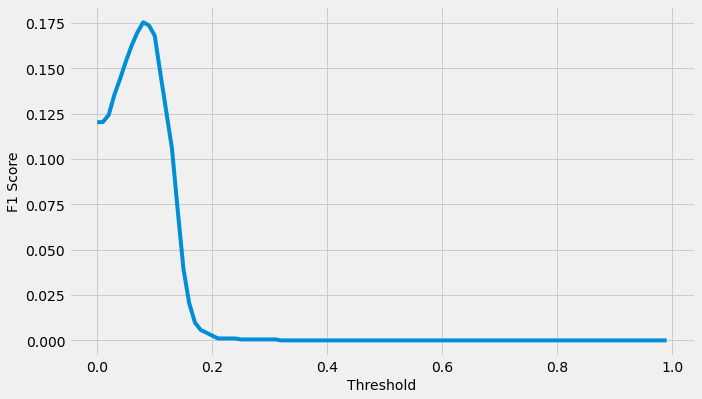

In [56]:
get_optimal_f1_thresh(train_df[TARGET_COL], lgb_oof)

In [58]:
xgb_study = optuna.create_study(direction='maximize')
xgb_obj_func = lambda trial: objective(trial, train_df_low_mem, features, TARGET_COL, 'XGB', True) 
xgb_study.optimize(xgb_obj_func, n_jobs=-1, n_trials=N_TRAILS, callbacks=[lambda study, trial: gc.collect()])

[I 2022-11-13 12:56:09,188] A new study created in memory with name: no-name-b702934c-6878-44ef-80b3-909a555b3053
[I 2022-11-13 12:56:44,793] Trial 2 finished with value: 0.6504114250987542 and parameters: {'random_state': 19920803, 'n_estimators': 25000, 'learning_rate': 0.04019001395751081, 'max_depth': 9, 'reg_lambda': 11.39061928884372, 'colsample_bytree': 0.29983172514892353, 'subsample': 0.12040992885478125, 'reg_alpha': 0.2927129106460372, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'use_label_encoder': False, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}. Best is trial 2 with value: 0.6504114250987542.
[I 2022-11-13 12:56:51,958] Trial 1 finished with value: 0.6619677909450015 and parameters: {'random_state': 19920803, 'n_estimators': 25000, 'learning_rate': 0.017185609508306974, 'max_depth': 7, 'reg_lambda': 60.06750284721908, 'colsample_bytree': 0.6144520482445287, 'subsample': 0.48150800521938364, 'reg_alpha': 0.00041265239449872276, 'objective': 'bi

In [59]:
xgb_best_params = xgb_study.best_params
xgb_best_params

{'random_state': 19920803,
 'n_estimators': 25000,
 'learning_rate': 0.06896528229967151,
 'max_depth': 3,
 'reg_lambda': 1.1940345602817362e-06,
 'colsample_bytree': 0.3718695225192066,
 'subsample': 0.2867532519462104,
 'reg_alpha': 2.0321936580360216,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'use_label_encoder': False,
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor'}

In [67]:
XGB_THRESHOLD = 0.09

In [68]:
xgb=XGBClassifier(**xgb_best_params)
xgb_preds, xgb_scores, xgb_model, xgb_oof = run_clf(xgb, fit_params, train_df_low_mem, test_df_low_mem,
                                                    features, TARGET_COL, folds=N_FOLDS, threshold=XGB_THRESHOLD)


------------- Fold 1 -------------
[0]	validation_0-logloss:0.642707	validation_1-logloss:0.642737
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 200 rounds.
Stopping. Best iteration:
[159]	validation_0-logloss:0.223301	validation_1-logloss:0.22744


F1 for validation set is 0.18059


------------- Fold 2 -------------
[0]	validation_0-logloss:0.642745	validation_1-logloss:0.642723
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 200 rounds.
Stopping. Best iteration:
[176]	validation_0-logloss:0.222765	validation_1-logloss:0.225749


F1 for validation set is 0.17207


------------- Fold 3 -------------
[0]	validation_0-logloss:0.641805	validation_1-logloss:0.641797
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until

In [69]:
np.mean(xgb_scores), np.std(xgb_scores) #0.661921, 0.1714089, 0.173785, 0.174172

(0.17597300000000002, 0.009799976581604678)

In [70]:
get_feature_importance(xgb_model, train_df_low_mem, features)

,Feature,Importance
18,engine_type_age_of_car_median,0.014261
9,gross_weight,0.012361
38,engine_type_population_density_avg,0.010163
213,model_age_of_car_avg,0.008708
11,rpm_pow,0.008230
10,bhp,0.008139
73,steering_type_age_of_car_avg,0.007896
108,ncap_rating_policy_tenure_avg,0.007760
17,engine_type_age_of_car_avg,0.007714
322,segment_population_density_diff,0.007683


In [71]:
xgb_preds, len(xgb_preds)

(array([0.14011053, 0.05452685, 0.03950413, ..., 0.05584584, 0.09194188,
        0.0185506 ]), 39063)

In [72]:
min(xgb_preds), max(xgb_preds)

(0.011137367982883006, 0.21400947216898203)

0.09

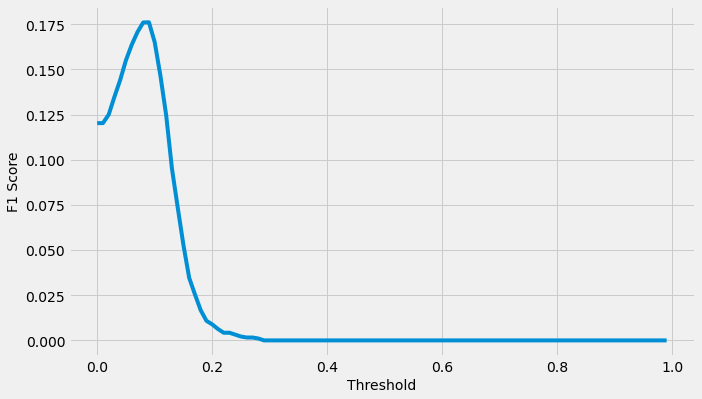

In [73]:
get_optimal_f1_thresh(train_df[TARGET_COL], xgb_oof)

In [ ]:
ctb_study = optuna.create_study(direction='maximize')
ctb_obj_func = lambda trial: objective(trial, train_df_low_mem, features, TARGET_COL, 'CTB', False)
ctb_study.optimize(ctb_obj_func, n_jobs=-1, n_trials=N_TRAILS, callbacks=[lambda study, trial: gc.collect()])

[I 2022-11-13 06:05:43,169] A new study created in memory with name: no-name-bc5ec314-ac5a-4623-8a1d-3f615c34375d
[I 2022-11-13 06:06:06,126] Trial 0 finished with value: 0.6597194773625037 and parameters: {'random_state': 19920803, 'n_estimators': 25000, 'learning_rate': 0.07157616701118624, 'max_depth': 3, 'reg_lambda': 0.00036585076806167137, 'colsample_bytree': 0.1964380961036904, 'subsample': 0.22535721967196434, 'reg_alpha': 8.800204823922257e-07, 'loss_function': 'Logloss', 'max_bin': 355, 'min_data_in_leaf': 238, 'use_best_model': True, 'random_strength': 19.021941402505025, 'rsm': 0.3799074365799683}. Best is trial 0 with value: 0.6597194773625037.
[I 2022-11-13 06:06:07,451] Trial 7 finished with value: 0.6542852628380431 and parameters: {'random_state': 19920803, 'n_estimators': 25000, 'learning_rate': 0.08223238148303187, 'max_depth': 8, 'reg_lambda': 0.2803054229028686, 'colsample_bytree': 0.5591101080585609, 'subsample': 0.15240694712916059, 'reg_alpha': 0.003888632800504

In [ ]:
ctb_best_params = ctb_study.best_params
del ctb_best_params['colsample_bytree']
del ctb_best_params['reg_alpha']

ctb_best_params

{'random_state': 19920803,
 'n_estimators': 25000,
 'learning_rate': 0.05438046450314171,
 'max_depth': 4,
 'reg_lambda': 1.7367683044040153e-08,
 'subsample': 0.5741886343331567,
 'loss_function': 'Logloss',
 'max_bin': 390,
 'min_data_in_leaf': 179,
 'use_best_model': True,
 'random_strength': 18.768159318666587,
 'rsm': 0.22635002547924474}

In [ ]:
CTB_THRESHOLD = 0.09

In [ ]:
ctb = CatBoostClassifier(**ctb_best_params)
ctb_preds, ctb_scores, ctb_model, ctb_oof = run_clf(ctb, fit_params, train_df_low_mem, test_df_low_mem,
                                                    features, TARGET_COL, folds = N_FOLDS, threshold=CTB_THRESHOLD)


------------- Fold 1 -------------
0:	learn: 0.6320791	test: 0.6321659	test1: 0.6321527	best: 0.6321527 (0)	total: 5.22ms	remaining: 2m 10s
500:	learn: 0.2207546	test: 0.2208287	test1: 0.2282928	best: 0.2281836 (408)	total: 2.24s	remaining: 1m 49s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2279862777
bestIteration = 546

Shrink model to first 547 iterations.

F1 for validation set is 0.16964


------------- Fold 2 -------------
0:	learn: 0.6320688	test: 0.6321604	test1: 0.6321787	best: 0.6321787 (0)	total: 5.17ms	remaining: 2m 9s
500:	learn: 0.2208247	test: 0.2208989	test1: 0.2257871	best: 0.2256713 (470)	total: 2.21s	remaining: 1m 48s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2256712867
bestIteration = 470

Shrink model to first 471 iterations.

F1 for validation set is 0.17386


------------- Fold 3 -------------
0:	learn: 0.6320832	test: 0.6321700	test1: 0.6321640	best: 0.6321640 (0)	total: 5.08ms	remaining: 2m 6s
500:	learn: 0.2

In [ ]:
np.mean(ctb_scores), np.std(ctb_scores) #0.174631

(0.169193, 0.013711860595849128)

In [ ]:
show_all(get_feature_importance(ctb_model, train_df_low_mem, features).reset_index(drop=True))

,Feature,Importance
0,policy_tenure,21.573713
1,age_of_car,18.435758
2,tE_area_cluster,5.345227
3,age_of_policyholder,3.220667
4,bhp,2.744224
5,ncap_rating,2.395964
6,tE_segment,2.179387
7,tE_is_speed_alert,2.144103
8,rpm_torque,2.046781
9,tE_is_tpms,1.966206


In [ ]:
ctb_preds, len(ctb_preds)

(array([0.13901363, 0.05520424, 0.04567687, ..., 0.05877775, 0.08677952,
        0.02479411]), 39063)

In [ ]:
min(ctb_preds), max(ctb_preds)

(0.0012490124667500922, 0.20380632789322375)

0.08

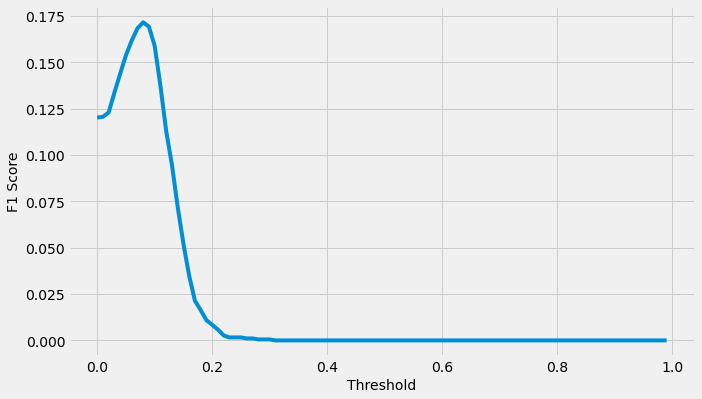

In [ ]:
get_optimal_f1_thresh(train_df_low_mem[TARGET_COL].values, ctb_oof)

In [74]:
final_sub = df_submission.copy()

In [75]:
final_sub[TARGET_COL] = xgb_preds
#(0.5 * lgb_preds) + (0.5 * xgb_preds)

In [76]:
final_sub[TARGET_COL] = np.where(final_sub[TARGET_COL] > XGB_THRESHOLD, 1, 0)

In [77]:
final_sub[TARGET_COL].value_counts()

0    31200
1     7863
Name: is_claim, dtype: int64

In [78]:
final_sub[TARGET_COL].value_counts(normalize=True)

0    0.79871
1    0.20129
Name: is_claim, dtype: float64

In [79]:
final_sub.head()

,policy_id,is_claim
0,ID58593,1
1,ID58594,0
2,ID58595,0
3,ID58596,0
4,ID58597,0


In [80]:
ALGO = 'XGB'
MODEL_NAME = f'{ALGO}_{XGB_THRESHOLD}T'
FILE_TIMESTAMP = datetime.now().strftime('%m%d%Y_%H%M')
OUTPUT_FILE_NAME = f"sub_{MODEL_NAME}_{FILE_TIMESTAMP}.csv"
OUTPUT_FILE_NAME

'sub_XGB_0.09T_11132022_1304.csv'

In [81]:
final_sub.to_csv(OUTPUT_FILE_NAME, index=False)